In [307]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from functools import reduce
import random as rd
import seaborn as sns
import pandas as pd
import numpy as np
import math 
import csv

In [308]:
class TextGenerator:
    #Não consengui coloter os dados por meio do front ate o tempo dessa entrega. Esses dados representão os     tamanhos das palvras em um determinado texto e o tempo hipotetico de leitura de cada palavra. Sim isso      vai polur o modelo mas creio que quando tiver dados esperimentais coletados os modoles irão servir.
    READ_FILE = "input.txt"
    TARGET_FILE = "./text/text7.csv"
    lines = []
    angular = []
    newLine = []
    rows = [['last word', 'current word', 'next word', 'time']]
    avgSpeed = 265 
    MINUTE_IN_MS = 60000
    avgWordLen = 0

    def __init__(self):
        with open(self.READ_FILE, encoding='utf8') as f:
            self.lines = f.readlines()

        for line in self.lines:
            self.newLine += line.split(" ")
            self.angular += self.newLine

        self.avgWordLen = self.avgWordLength()

        new_row = []
        for i in range(len(self.newLine)):
            if i == 0: 
                new_row = [
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i + 1])),
                        ]
            elif i == len(self.newLine) - 1:
                new_row = [
                            str(len(self.newLine[i - 1])),
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i])),
                        ]
            else:
                new_row = [
                            str(len(self.newLine[i - 1])),
                            str(len(self.newLine[i])),
                            str(len(self.newLine[i + 1])),
                        ]
            self.rows += [new_row + [str(self.setTimeGivenLength(self.newLine[i]))]]
        

    def setTimeGivenLength(self, word):
        avgWordLen = self.avgWordLength()
        wordLen = len(word)
        timeInMs = self.MINUTE_IN_MS / self.avgSpeed 
        #se menor negativo
        dist = wordLen - avgWordLen
        return (timeInMs + (dist * 12)) + (20 * np.random.normal(0,0.333))


    def avgWordLength(self):
        count = reduce(lambda x,y: x + len(y), self.angular, 0)
        return count / len(self.angular)

    def generateTextLegthFile(self, target = TARGET_FILE):
        with open(target, 'w', newline='') as file:
            writer = csv.writer(file, delimiter=',')
            writer.writerows(self.rows)

In [309]:
text_generator = TextGenerator()
text_generator.generateTextLegthFile('./text/text30.csv')
words_in_text = np.array(text_generator.angular)
words_df = pd.DataFrame(data=words_in_text, index=None,columns=['words'])
words_df

,words
0,Pernambuco
1,é
2,uma
3,das
4,27
...,...
2216,mesmo
2217,nome
2218,do
2219,compositor


In [310]:
df = pd.read_csv("./text/text30.csv")
df

,last word,current word,next word,time
0,10,10,1,281.255696
1,10,1,3,181.396355
2,1,3,3,198.259438
3,3,3,2,190.812773
4,3,2,8,179.616242
...,...,...,...,...
635,2,5,4,230.449750
636,5,4,2,199.265544
637,4,2,10,198.944607
638,2,10,15,279.480253


<AxesSubplot:ylabel='Frequency'>

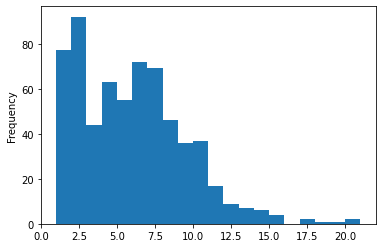

In [311]:
#Hipotes o tamnho das palavras em um testo qualquer, segue uma distribuição normal?
df['current word'].plot.hist(bins=20)

#Não é conclusivo dizer que as palavras seguem uma distribuição normal

<AxesSubplot:title={'center':'Frequencia de Palavras'}, xlabel='words'>

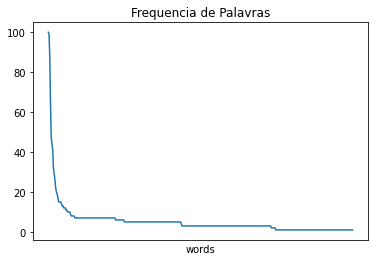

In [312]:
#Fato a frequencia de palavras em qualquer texto escrito pela humanidade em qualquer lingua tende a uma #distribuição de pareto. Vamos avaliar isso para notto data set
n = words_df.value_counts()
n.plot(title="Frequencia de Palavras", xticks=[])

In [313]:
#Problema! Atualmente como esta iplementado o Power Reader tem sua velocideade definida por Palavras Por Minutos, que em uma pessoa "normal" esta na cassa dos 265 a 300. Com isso temos que o tempo para cada palavra é igual a 226ms. Vimos a cima que as palavras em um texto mudam de tamanho e algumas não são tão comuns como as outras. A pergunta é como fazer com que palavras maiores fiquem mais tempo e palavras menores fiquem menos tempo afim de conseguir uma média? Queremos criar um modelo que dado uma palavra nos dê uma porcentagem para ser multiplicada 

In [314]:
#Seperar Daados

df_st = df.copy()
x = df_st.drop(columns=['time'])
y = df_st['time']

In [315]:
# Primeira solução possivel, regressão. Podemos tentar fazer com que cada numero nos de um tempo medio

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 200)

scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

regressor = LinearRegression()
regressor = regressor.fit(X_train, y_train)

# Coeficient of every dimension in Multiplynomial Regression 
coeff_df = pd.DataFrame(regressor.coef_, x.columns, columns=['Coefficient'])
coeff_df 

,Coefficient
last word,-0.452904
current word,40.887375
next word,-0.629151


In [316]:
y_pred = regressor.predict(X_test)
yDF = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
yDF

,Actual,Predicted
300,246.115853,243.675537
45,198.342536,209.309003
129,277.418851,278.477921
141,181.701851,185.292438
235,229.473682,222.687882
...,...,...
384,284.622667,280.509031
611,222.332694,222.813984
252,327.286394,315.897859
154,184.271607,186.290238


In [317]:
cross_regressor = LinearRegression()
scores = cross_val_score(cross_regressor, X_test , y_test, cv = 10)
results = {"Accuracy" : scores.mean(), "uncertainty" : scores.std() * 2}
results

{'Accuracy': 0.9718110780759017, 'uncertainty': 0.026104990580637234}

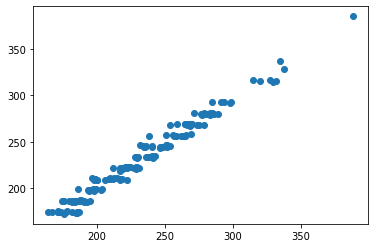

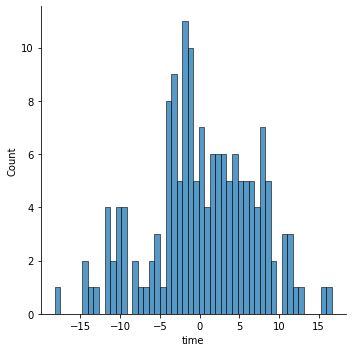

In [321]:
plt.scatter(y_test, y_pred, cmap='Rainbow')
sns.displot((y_test-y_pred),bins=50)